# Explorando los metaparametros con tecnicas de validacion

In [ ]:
!rm -r mnist
!unzip mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/train/5/2606.png  

## Se guardan las imagenes que se usaran en el training, valid y test sets en arreglos

In [ ]:
from glob import glob
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

## Se ponen aleatorios los datos

In [ ]:
import numpy as np
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

## Se organizan los arreglos anteriores de manera aleatoria




In [ ]:
from PIL import Image   # lee imagenes como arrays

# se cargan los datos del train set
N_train = len(train_files)
X_train, Y_train = [], []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

# se cargan los datos del valid set
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )
  
# se cargan los datos del test set
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )  

len(X_train), len(X_valid), len(X_test)

(6000, 2000, 992)

## Grafico histogramas de los arreglos para comprobar que esten balanceados

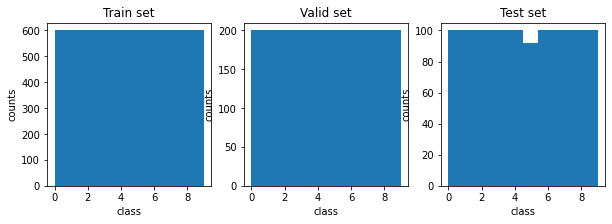

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

## Graficando algunos datos


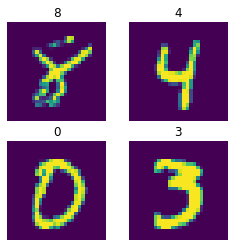

In [ ]:
fig = plt.figure(figsize=(4,4))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*5])
  plt.title(Y_test[i*5])
  plt.axis(False)
plt.show()

## Convirtiendo a tensores

In [ ]:
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

## Funcion que se realizó en clase, que genera graficas de la matriz de confusion

In [ ]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

## Funcion que calcula el loss, el f1_score y la accuracy por epoca

In [ ]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train, f1_train, acc_train = [], [], []
  loss_valid, f1_valid, acc_valid = [], [], []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)   #grafica la matriz de confusion
  return f1_valid[-1]

# Usando Grid search como tecnica de validacion

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm    # para ver una barra de progreso del entrenamiento del modelo

In [ ]:
lr_list = [0.001,0.01,0.1]    # learning rate
wd_list = [0.001,0.01,0.1]    # decaimiento de peso
ne_list = [50,100,150]     # numero de epocas

# Para el modelo 1

In [ ]:
bs_list = [100,200,300]     # bach sizes
hd_list = [20,50,100]    # numero de neuronas en las capas oculta

f1_mayor = 0          # inicializo la variable f1_score donde guardare el f1_score mas alto 
                      # para saber cuales son mis metaparametros mas optimos
ne_optimo, lr_optimo, wd_optimo, bs_optimo = 0, 0, 0, 0

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

# iteraciones
for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          # modelo 1:
          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          f1 = train_valid(model,ne,optimizer,criterion)
          if f1 > f1_mayor:    # voy comparando y guardando el valor de f1_score mas alto
            f1_mayor = f1
            ne_optimo, lr_optimo, wd_optimo, bs_optimo = ne, lr, wd, bs

          print('###################\n')

          pbar.update()
pbar.close()

In [ ]:
print("Resultados para modelo 1: \n")
print("El f1_score mayor es = " + str(f1_mayor) + "\n")
print("Los metaparametros optimos son: numero de epocas = {}, learning rate = {}, weight decay = {}, batch size = {}".format(ne_optimo, lr_optimo, wd_optimo, bs_optimo))

Resultados para modelo 1: 

El f1_score mayor es = 0.9100416242662721

Los metaparametros optimos son: numero de epocas = 150, learning rate = 0.001, weight decay = 0.001, batch size = 300


# Para el modelo 2

In [ ]:
bs_list = [500,1000,2000]     # bach sizes     (lo quintuple)
hd_list = [20,50,100]    # numero de neuronas en las capas oculta   (los deje constante)

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

f1_mayor = 0 
ne_optimo, lr_optimo, wd_optimo, bs_optimo = 0, 0, 0, 0

# iteraciones
for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          # modelo 2:
          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          f1 = train_valid(model,ne,optimizer,criterion)
          if f1 > f1_mayor:    # voy comparando y guardando el valor de f1_score mas alto
            f1_mayor = f1
            ne_optimo, lr_optimo, wd_optimo, bs_optimo = ne, lr, wd, bs
          print('###################\n')

          pbar.update()
pbar.close()


# Para modelo 3

In [ ]:
print("Resultados para modelo 2: \n")
print("El f1_score mayor es = " + str(f1_mayor) + "\n")
print("Los metaparametros optimos son: numero de epocas = {}, learning rate = {}, weight decay = {}, batch size = {}".format(ne_optimo, lr_optimo, wd_optimo, bs_optimo))

Resultados para modelo 2: 

El f1_score mayor es = 0.9048624572867425

Los metaparametros optimos son: numero de epocas = 150, learning rate = 0.001, weight decay = 0.001, batch size = 500


# Reporte de resultados

Los mejores resultados se obtuvieron con el modelo 1, el cual tenia la misma cantidad de neuronas que el modelo 2 (20,50,100) y tamaño de batch size (100,200,300), a diferencia del modelo 2 que tenia el quintuple (500,1000,2000).

Los metaparametros optimos que se encontraron en ambos modelos son: el número de épocas optimo fue la de mayor, es decir 150 epocas, el learning rate y weight decay optimos fueron los de menor valor, es decir 0.001. Con respecto al batch size, para el primer modelo el valor optimo fue el mayor, es decir 300, pero para el segundo modelo el batch size optimo fue el menor, es decir 500, lo que parece indicar que un mayor batch size no implica un mejor modelo.
